In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install jiwer
!pip install torchmetrics

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import ast
from collections import Counter
from typing import List, Dict, Tuple
import random
import pandas as pd

# Preprocessing

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_and_save_csv(csv_path: str, base_name: str,
                       train_ratio=0.8, val_ratio=0.1):
    """
    Splits one CSV into train/val/test and saves them.
    """
    df = pd.read_csv(csv_path)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle

    n = len(df)
    train_end = int(train_ratio * n)
    val_end = int((train_ratio + val_ratio) * n)

    splits = {
        "train": df.iloc[:train_end],
        "val": df.iloc[train_end:val_end],
        "test": df.iloc[val_end:]
    }

    for split_name, split_df in splits.items():
        path = f"{base_name}_{split_name}.csv"
        split_df.to_csv(path, index=False)
        print(f"✅ Saved {len(split_df)} rows → {path}")


split_and_save_csv("/content/drive/MyDrive/datasets/old_tokens/c_tokens_clean.csv", "obf_c_code")
split_and_save_csv("/content/drive/MyDrive/datasets/old_tokens/cpp_tokens_1_clean.csv", "obf_cpp_code")

✅ Saved 800 rows → obf_c_code_train.csv
✅ Saved 100 rows → obf_c_code_val.csv
✅ Saved 100 rows → obf_c_code_test.csv
✅ Saved 800 rows → obf_cpp_code_train.csv
✅ Saved 100 rows → obf_cpp_code_val.csv
✅ Saved 100 rows → obf_cpp_code_test.csv


# Metrics

In [ ]:
from torchmetrics.text import BLEUScore
from jiwer import wer, cer

class MetricsCalculator:
    """
    Calculate BLEU, CER, and WER metrics for sequence reconstruction.
    """
    def __init__(self, idx_to_token: Dict[int, str], pad_idx: int = 0):
        self.idx_to_token = idx_to_token
        self.pad_idx = pad_idx

        # Initialize BLEU calculator
        self.bleu_calculator = BLEUScore(n_gram=4)

    def indices_to_tokens(self, indices: torch.Tensor) -> List[List[str]]:
        """
        Convert token indices to list of token strings.

        Args:
            indices: (batch_size, seq_len)

        Returns:
            List of token lists for each sequence
        """
        batch_sequences = []
        for seq in indices:
            tokens = []
            for idx in seq:
                idx_val = idx.item()
                if idx_val != self.pad_idx:  # Skip padding
                    tokens.append(self.idx_to_token.get(idx_val, '<UNK>'))
            batch_sequences.append(tokens)
        return batch_sequences

    def tokens_to_string(self, tokens: List[str]) -> str:
        """Join tokens into a single string."""
        return ' '.join(tokens)

    def calculate_bleu(self, predictions: torch.Tensor, targets: torch.Tensor) -> float:
        """
        Calculate BLEU score.

        Args:
            predictions: (batch_size, seq_len) - predicted token indices
            targets: (batch_size, seq_len) - target token indices

        Returns:
            BLEU score (0-1)
        """
        # Convert indices to tokens
        pred_tokens = self.indices_to_tokens(predictions)
        target_tokens = self.indices_to_tokens(targets)

        # Convert to strings for BLEU calculation
        pred_strings = [self.tokens_to_string(tokens) for tokens in pred_tokens]
        target_strings = [[self.tokens_to_string(tokens)] for tokens in target_tokens]

        # Calculate BLEU
        try:
            bleu_score = self.bleu_calculator(pred_strings, target_strings)
            return bleu_score.item()
        except:
            return 0.0

    def calculate_cer(self, predictions: torch.Tensor, targets: torch.Tensor) -> float:
        """
        Calculate Character Error Rate (CER).

        Args:
            predictions: (batch_size, seq_len) - predicted token indices
            targets: (batch_size, seq_len) - target token indices

        Returns:
            CER score (lower is better, 0 is perfect)
        """
        # Convert indices to tokens
        pred_tokens = self.indices_to_tokens(predictions)
        target_tokens = self.indices_to_tokens(targets)

        # Convert to strings
        pred_strings = [self.tokens_to_string(tokens) for tokens in pred_tokens]
        target_strings = [self.tokens_to_string(tokens) for tokens in target_tokens]

        # Calculate CER for each pair and average
        try:
            cer_scores = []
            for pred, target in zip(pred_strings, target_strings):
                if len(target) > 0:  # Avoid empty references
                    cer_score = cer(target, pred)
                    cer_scores.append(cer_score)

            return np.mean(cer_scores) if cer_scores else 0.0
        except:
            return 0.0

    def calculate_wer(self, predictions: torch.Tensor, targets: torch.Tensor) -> float:
        """
        Calculate Word Error Rate (WER).

        Args:
            predictions: (batch_size, seq_len) - predicted token indices
            targets: (batch_size, seq_len) - target token indices

        Returns:
            WER score (lower is better, 0 is perfect)
        """
        # Convert indices to tokens
        pred_tokens = self.indices_to_tokens(predictions)
        target_tokens = self.indices_to_tokens(targets)

        # Convert to strings
        pred_strings = [self.tokens_to_string(tokens) for tokens in pred_tokens]
        target_strings = [self.tokens_to_string(tokens) for tokens in target_tokens]

        # Calculate WER for each pair and average
        try:
            wer_scores = []
            for pred, target in zip(pred_strings, target_strings):
                if len(target.split()) > 0:  # Avoid empty references
                    wer_score = wer(target, pred)
                    wer_scores.append(wer_score)

            return np.mean(wer_scores) if wer_scores else 0.0
        except:
            return 0.0

    def calculate_all_metrics(self, predictions: torch.Tensor, targets: torch.Tensor) -> Dict[str, float]:
        """
        Calculate all metrics (BLEU, CER, WER).

        Args:
            predictions: (batch_size, seq_len) - predicted token indices
            targets: (batch_size, seq_len) - target token indices

        Returns:
            Dictionary with all metrics
        """
        return {
            'bleu': self.calculate_bleu(predictions, targets),
            'cer': self.calculate_cer(predictions, targets),
            'wer': self.calculate_wer(predictions, targets)
        }

# Model (Phase 1)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class Encoder(nn.Module):
    """Transformer Encoder using PyTorch's built-in TransformerEncoder."""

    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=6,
                 dim_feedforward=2048, dropout=0.1, max_len=5000):
        super().__init__()

        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)

        # Using PyTorch's built-in TransformerEncoderLayer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        # Stack multiple encoder layers
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        """
        Args:
            src: (batch_size, seq_len)
            src_mask: (seq_len, seq_len) - attention mask
            src_key_padding_mask: (batch_size, seq_len) - padding mask
        """
        # Embedding with scaling
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        src = self.dropout(src)

        # Pass through transformer encoder
        output = self.transformer_encoder(
            src,
            mask=src_mask,
            src_key_padding_mask=src_key_padding_mask
        )

        return output

class Decoder(nn.Module):
    """Transformer Decoder using PyTorch's built-in TransformerDecoder."""

    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=6, dim_feedforward=2048, dropout=0.1, max_len=5000):
        super().__init__()

        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)

        # Using PyTorch's built-in TransformerDecoderLayer
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        # Stack multiple decoder layers
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.dropout = nn.Dropout(dropout)
        self.output_projection = nn.Linear(d_model, vocab_size)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        """
        Args:
            tgt: (batch_size, tgt_seq_len)
            memory: (batch_size, src_seq_len, d_model) - encoder output
            tgt_mask: (tgt_seq_len, tgt_seq_len) - causal mask
            memory_mask: (tgt_seq_len, src_seq_len) - cross attention mask
            tgt_key_padding_mask: (batch_size, tgt_seq_len) - target padding mask
            memory_key_padding_mask: (batch_size, src_seq_len) - source padding mask
        """
        # Embedding with scaling
        tgt = self.embedding(tgt) * math.sqrt(self.d_model)
        tgt = self.pos_encoder(tgt)
        tgt = self.dropout(tgt)

        # Pass through transformer decoder
        output = self.transformer_decoder(
            tgt=tgt,
            memory=memory,
            tgt_mask=tgt_mask,
            memory_mask=memory_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )

        # Project to vocabulary size
        output = self.output_projection(output)

        return output


class Model1(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, nhead=8,
                 num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048,
                 dropout=0.1, max_len=5000):
        super().__init__()

        self.encoder = Encoder(
            vocab_size=src_vocab_size,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_encoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            max_len=max_len
        )

        self.decoder1 = Decoder(
            vocab_size=tgt_vocab_size,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            max_len=max_len
        )


        self.decoder2 = Decoder(
            vocab_size=tgt_vocab_size,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            max_len=max_len
        )

    def forward(self, src, tgt, flag, src_mask=None, tgt_mask=None, memory_mask=None, src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):

        # Encode source sequence
        memory = self.encoder(
            src=src,
            src_mask=None,
            src_key_padding_mask=src_key_padding_mask
        )

        memory_key_padding_mask = src_key_padding_mask

        if flag:    # for switching between 2 languages
            output = self.decoder1(
                tgt=tgt,
                memory=memory,
                tgt_mask=tgt_mask,
                memory_mask=memory_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=memory_key_padding_mask
            )

        else:
            output = self.decoder2(
                tgt=tgt,
                memory=memory,
                tgt_mask=tgt_mask,
                memory_mask=memory_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=memory_key_padding_mask
            )

        return output

In [ ]:
class PositionalEncoding(nn.Module):
    """Positional encoding for transformer inputs."""

    def __init__(self, d_model, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]


# Data Loaders

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import ast
from collections import Counter
from typing import List, Dict, Tuple

class TokenizedCodeDataset(Dataset):
    def __init__(self, csv_path: str, column: str = "Obfuscated_Tokens",
                 max_seq_len: int = 512, min_seq_len: int = 5,
                 vocab_size: int = None, test_mode: bool = False, vocab: List[str] = None):
        """
        Args:
            csv_path: path to the CSV file
            column: column name containing token sequences
        """
        self.max_seq_len = max_seq_len
        self.min_seq_len = min_seq_len
        self.column = column

        # Special tokens
        self.PAD_TOKEN = '<PAD>'
        self.UNK_TOKEN = '<UNK>'
        self.SOS_TOKEN = '<SOS>'
        self.EOS_TOKEN = '<EOS>'

        # Load data from CSV
        self.sequences = self._load_data(csv_path, test_mode)

        # Build or use given vocab
        if vocab is None:
            self.vocab = self._build_vocab(vocab_size)
        else:
            self.vocab = vocab

        self.token_to_idx = {tok: idx for idx, tok in enumerate(self.vocab)}
        self.idx_to_token = {idx: tok for tok, idx in self.token_to_idx.items()}

        self.pad_idx = self.token_to_idx[self.PAD_TOKEN]

        # Encode sequences to integer indices
        self.encoded_sequences = self._encode_sequences()

        print(f"✅ Loaded {len(self.encoded_sequences)} sequences from {csv_path}")
        print(f"Vocabulary size: {len(self.vocab)}")
        print(f"Average sequence length: {sum(len(s) for s in self.sequences) / len(self.sequences):.1f}")

    def _load_data(self, csv_path: str, test_mode: bool) -> List[List[str]]:
        df = pd.read_csv(csv_path)
        sequences = []

        for i, tokens_str in enumerate(df[self.column]):
            if test_mode and i >= 1000:
                break

            try:
                tokens = ast.literal_eval(tokens_str)
                if isinstance(tokens, list) and len(tokens) >= self.min_seq_len:
                    tokens = [str(tok) for tok in tokens]
                    if len(tokens) > self.max_seq_len - 2:
                        tokens = tokens[: self.max_seq_len - 2]
                    sequences.append(tokens)
            except Exception as e:
                print(f"Skipping row {i}: {e}")
                continue

        if not sequences:
            raise ValueError(f"No valid token lists found in column '{self.column}'")

        return sequences

    def _build_vocab(self, vocab_size: int = None, min_freq: int = 100) -> List[str]:
        token_counts = Counter()
        for seq in self.sequences:
            token_counts.update(seq)
        vocab = [self.PAD_TOKEN, self.UNK_TOKEN, self.SOS_TOKEN, self.EOS_TOKEN]
        filtered = [(t, c) for t, c in token_counts.items() if c >= min_freq]

        filtered.sort(key=lambda x: x[1], reverse=True)

        if vocab_size is not None:
            filtered = filtered[: vocab_size - len(vocab)]

        vocab.extend([t for t, _ in filtered])

        return vocab

    def _encode_sequences(self) -> List[List[int]]:
        encoded = []
        unk = self.token_to_idx[self.UNK_TOKEN]
        sos = self.token_to_idx[self.SOS_TOKEN]
        eos = self.token_to_idx[self.EOS_TOKEN]

        for seq in self.sequences:
            full_seq = [self.SOS_TOKEN] + seq + [self.EOS_TOKEN]
            indices = [self.token_to_idx.get(tok, unk) for tok in full_seq]
            encoded.append(indices)

        return encoded

    def __len__(self):
        return len(self.encoded_sequences)

    def __getitem__(self, idx):
        seq = self.encoded_sequences[idx]
        src = torch.tensor(seq, dtype=torch.long)
        tgt_input = torch.tensor(seq[:-1], dtype=torch.long)
        tgt_output = torch.tensor(seq[1:], dtype=torch.long)

        return {
            'src': src,
            'tgt_input': tgt_input,
            'tgt_output': tgt_output,
            'src_len': len(src),
            'tgt_len': len(tgt_input)
        }


def collate_fn(batch: List[Dict]) -> Dict[str, torch.Tensor]:
    src = [b['src'] for b in batch]
    tgt_in = [b['tgt_input'] for b in batch]
    tgt_out = [b['tgt_output'] for b in batch]
    src_lens = torch.tensor([b['src_len'] for b in batch])
    tgt_lens = torch.tensor([b['tgt_len'] for b in batch])

    pad_idx = 0

    src_pad = pad_sequence(src, batch_first=True, padding_value=pad_idx)
    tgt_in_pad = pad_sequence(tgt_in, batch_first=True, padding_value=pad_idx)
    tgt_out_pad = pad_sequence(tgt_out, batch_first=True, padding_value=pad_idx)

    return {
        'src': src_pad,
        'tgt_input': tgt_in_pad,
        'tgt_output': tgt_out_pad,
        'src_key_padding_mask': src_pad == pad_idx,
        'tgt_key_padding_mask': tgt_in_pad == pad_idx,
        'src_lens': src_lens,
        'tgt_lens': tgt_lens
    }


def create_dataloader(csv_path: str, column: str = "Obfuscated_Tokens",
                      batch_size: int = 32, shuffle: bool = True,
                      max_seq_len: int = 512, min_seq_len: int = 5,
                      vocab_size: int = None, test_mode: bool = False,
                      num_workers: int = 0, vocab: List[str] = None):

    dataset = TokenizedCodeDataset(
        csv_path=csv_path,
        column=column,
        max_seq_len=max_seq_len,
        min_seq_len=min_seq_len,
        vocab_size=vocab_size,
        test_mode=test_mode,
        vocab=vocab
    )

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available(),
        collate_fn=collate_fn
    )
    return dataloader, dataset

# Loss

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import math
import time
from typing import Dict, Tuple
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

class ReconstructionLoss(nn.Module):
    """
    Reconstruction loss for sequence-to-sequence learning.
    Uses CrossEntropyLoss with padding token masking.
    """

    def __init__(self, vocab_size: int, pad_idx: int = 0, label_smoothing: float = 0.0):
        super().__init__()
        self.vocab_size = vocab_size
        self.pad_idx = pad_idx
        self.criterion = nn.CrossEntropyLoss(
            ignore_index=pad_idx,  # Ignore padding tokens in loss
            label_smoothing=label_smoothing
        )

    def forward(self, predictions: torch.Tensor, targets: torch.Tensor,
                target_mask: torch.Tensor = None) -> Dict[str, torch.Tensor]:
        """
        Calculate reconstruction loss.

        Args:
            predictions: (batch_size, seq_len, vocab_size)
            targets: (batch_size, seq_len)
            target_mask: (batch_size, seq_len) - True for real tokens

        Returns:
            Dictionary with loss and metrics
        """
        batch_size, seq_len, vocab_size = predictions.shape

        # Reshape for CrossEntropyLoss
        predictions_flat = predictions.view(-1, vocab_size)  # (batch_size * seq_len, vocab_size)
        targets_flat = targets.view(-1)  # (batch_size * seq_len,)

        # Calculate loss
        loss = self.criterion(predictions_flat, targets_flat)

        # Calculate accuracy (only for non-padding tokens)
        with torch.no_grad():
            pred_tokens = torch.argmax(predictions_flat, dim=-1)

            if target_mask is not None:
                mask_flat = target_mask.view(-1)
                correct = ((pred_tokens == targets_flat) & mask_flat).sum().float()
                total = mask_flat.sum().float()
            else:
                # Use ignore_index to exclude padding tokens
                valid_mask = targets_flat != self.pad_idx
                correct = ((pred_tokens == targets_flat) & valid_mask).sum().float()
                total = valid_mask.sum().float()

            accuracy = correct / (total + 1e-8)  # Avoid division by zero

        # Calculate perplexity
        perplexity = torch.exp(loss)

        return {
            'loss': loss,
            'accuracy': accuracy,
            'perplexity': perplexity,
            'num_tokens': total
        }

# Trainer

In [ ]:
def generate_square_subsequent_mask(sz: int, device: torch.device) -> torch.Tensor:
    """Generate causal mask for decoder self-attention."""
    mask = torch.triu(torch.ones(sz, sz, device=device) * float('-inf'), diagonal=1)
    return mask

def create_padding_mask(seq: torch.Tensor, pad_idx: int = 0) -> torch.Tensor:
    """Create padding mask - True for padding tokens."""
    return (seq == pad_idx)

class TransformerTrainer:
    """
    Trainer class for Transformer reconstruction training.
    """

    def __init__(self, model: nn.Module, vocab_size: int, idx_to_token: Dict[int, str], pad_idx: int = 0,
                 learning_rate: float = 1e-4, weight_decay: float = 1e-5,
                 label_smoothing: float = 0.1, warmup_steps: int = 4000):

        self.model = model
        self.vocab_size = vocab_size
        self.pad_idx = pad_idx
        self.device = next(model.parameters()).device

        # Loss function
        self.criterion = ReconstructionLoss(vocab_size, pad_idx, label_smoothing)

        # Optimizer with learning rate scheduling
        self.optimizer = optim.AdamW(
            model.parameters(),
            lr=learning_rate,
            betas=(0.9, 0.98),
            weight_decay=weight_decay
        )

        self.metrics_calculator = MetricsCalculator(idx_to_token, pad_idx)

        # Learning rate scheduler (Transformer-style warmup)
        self.warmup_steps = warmup_steps
        self.d_model = model.encoder.d_model if hasattr(model.encoder, 'd_model') else 512
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=7, gamma=0.1)

        # Training metrics
        self.train_losses_1 = []
        self.train_losses_2 = []
        self.train_accuracies_1 = []
        self.train_accuracies_2 = []
        self.val_losses_1 = []
        self.val_losses_2 = []
        self.val_accuracies_1 = []
        self.val_accuracies_2 = []
        self.val_bleu_1 = []
        self.val_bleu_2 = []
        self.val_cer_1 = []
        self.val_cer_2 = []
        self.val_wer_1 = []
        self.val_wer_2 = []
        self.step = 0

    def _get_lr_scale(self, step: int) -> float:
        """Learning rate scaling for warmup."""
        step = max(1, step)  # Avoid division by zero
        return (self.d_model ** -0.5) * min(step ** -0.5, step * (self.warmup_steps ** -1.5))

    def train_step(self, batch: Dict[str, torch.Tensor], flag: bool) -> Dict[str, float]:
        """Single training step."""
        self.model.train()
        self.optimizer.zero_grad()

        # Move batch to device
        src = batch['src'].to(self.device)
        tgt_input = batch['tgt_input'].to(self.device)
        tgt_output = batch['tgt_output'].to(self.device)

        batch_size, tgt_len = tgt_input.shape

        # Create masks
        src_key_padding_mask = create_padding_mask(src, self.pad_idx)
        tgt_key_padding_mask = create_padding_mask(tgt_input, self.pad_idx)
        tgt_mask = generate_square_subsequent_mask(tgt_len, self.device)

        # Forward pass
        output = self.model(
            src=src,
            tgt=tgt_input,
            flag = flag,
            tgt_mask = tgt_mask,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
        )

        loss_mask = ~tgt_key_padding_mask
        # Calculate loss
        loss_dict = self.criterion(output, tgt_output, loss_mask)
        loss = loss_dict['loss']

        # Backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

        # Update parameters
        self.optimizer.step()
        #self.scheduler.step()

        return {
            'loss': loss.item(),
            'accuracy': loss_dict['accuracy'].item(),
            'perplexity': loss_dict['perplexity'].item(),
            'lr': self.scheduler.get_lr()[0],
            'num_tokens': loss_dict['num_tokens'].item()
        }

    def validate(self, val_loader_1: DataLoader, val_loader_2: DataLoader) -> Dict[str, float]:
        """Validation loop."""
        self.model.eval()

        total_loss_1 = 0
        total_accuracy_1 = 0
        total_tokens_1 = 0
        total_bleu_1 = 0
        total_cer_1 = 0
        total_wer_1 = 0

        total_loss_2 = 0
        total_accuracy_2 = 0
        total_tokens_2 = 0
        total_bleu_2 = 0
        total_cer_2 = 0
        total_wer_2 = 0

        num_batches = 0

        with torch.no_grad():
            for batch_1, batch_2 in tqdm(zip(val_loader_1, val_loader_2), desc="Validating", leave=False):
                # Move batch to device
                src_1 = batch_1['src'].to(self.device)
                tgt_input_1 = batch_1['tgt_input'].to(self.device)
                tgt_output_1 = batch_1['tgt_output'].to(self.device)

                src_2 = batch_2['src'].to(self.device)
                tgt_input_2 = batch_2['tgt_input'].to(self.device)
                tgt_output_2 = batch_2['tgt_output'].to(self.device)

                batch_size, tgt_len_1 = tgt_input_1.shape
                batch_size, tgt_len_2 = tgt_input_2.shape

                # Create masks
                src_key_padding_mask_1 = create_padding_mask(src_1, self.pad_idx)
                tgt_key_padding_mask_1 = create_padding_mask(tgt_input_1, self.pad_idx)
                tgt_mask_1 = generate_square_subsequent_mask(tgt_len_1, self.device)

                src_key_padding_mask_2 = create_padding_mask(src_2, self.pad_idx)
                tgt_key_padding_mask_2 = create_padding_mask(tgt_input_2, self.pad_idx)
                tgt_mask_2 = generate_square_subsequent_mask(tgt_len_2, self.device)

                # Forward pass
                output_1 = self.model(
                    src=src_1,
                    tgt=tgt_input_1,
                    tgt_mask=tgt_mask_1,
                    flag=True,
                    src_key_padding_mask=src_key_padding_mask_1,
                    tgt_key_padding_mask=tgt_key_padding_mask_1,
                )

                output_2 = self.model(
                    src=src_2,
                    tgt=tgt_input_2,
                    tgt_mask=tgt_mask_2,
                    flag=False,
                    src_key_padding_mask=src_key_padding_mask_2,
                    tgt_key_padding_mask=tgt_key_padding_mask_2,
                )

                # Calculate loss
                loss_dict_1 = self.criterion(output_1, tgt_output_1, ~tgt_key_padding_mask_1)
                loss_dict_2 = self.criterion(output_2, tgt_output_2, ~tgt_key_padding_mask_2)

                predictions_1 = torch.argmax(output_1, dim=-1)
                predictions_2 = torch.argmax(output_2, dim=-1)

                metrics_1 = self.metrics_calculator.calculate_all_metrics(predictions_1, tgt_output_1)
                metrics_2 = self.metrics_calculator.calculate_all_metrics(predictions_2, tgt_output_2)

                # Accumulate metrics
                total_loss_1 += loss_dict_1['loss'].item()
                total_accuracy_1 += loss_dict_1['accuracy'].item() * loss_dict_1['num_tokens'].item()
                total_tokens_1 += loss_dict_1['num_tokens'].item()
                total_bleu_1 += metrics_1['bleu']
                total_cer_1 += metrics_1['cer']
                total_wer_1 += metrics_1['wer']

                total_loss_2 += loss_dict_2['loss'].item()
                total_accuracy_2 += loss_dict_2['accuracy'].item() * loss_dict_2['num_tokens'].item()
                total_tokens_2 += loss_dict_2['num_tokens'].item()
                total_bleu_2 += metrics_2['bleu']
                total_cer_2 += metrics_2['cer']
                total_wer_2 += metrics_2['wer']

                num_batches += 1

        avg_loss_1 = total_loss_1 / num_batches
        avg_accuracy_1 = total_accuracy_1 / total_tokens_1 if total_tokens_1 > 0 else 0
        avg_perplexity_1 = math.exp(avg_loss_1)
        avg_bleu_1 = total_bleu_1 / num_batches
        avg_cer_1 = total_cer_1 / num_batches
        avg_wer_1 = total_wer_1 / num_batches

        avg_loss_2 = total_loss_2 / num_batches
        avg_accuracy_2 = total_accuracy_2 / total_tokens_2 if total_tokens_2 > 0 else 0
        avg_perplexity_2 = math.exp(avg_loss_2)
        avg_bleu_2 = total_bleu_2 / num_batches
        avg_cer_2 = total_cer_2 / num_batches
        avg_wer_2 = total_wer_2 / num_batches

        return {
            'loss_1': avg_loss_1,
            'loss_2': avg_loss_2,
            'accuracy_1': avg_accuracy_1,
            'accuracy_2': avg_accuracy_2,
            'perplexity_1': avg_perplexity_1,
            'perplexity_2': avg_perplexity_2,
            'bleu_1': avg_bleu_1,
            'bleu_2': avg_bleu_2,
            'cer_1': avg_cer_1,
            'cer_2': avg_cer_2,
            'wer_1': avg_wer_1,
            'wer_2': avg_wer_2
        }

    def train_epoch(self, train_loader_1: DataLoader, train_loader_2: DataLoader, phase: int, val_loader_1: DataLoader = None,
                   val_loader_2: DataLoader = None, print_every: int = 100) -> Dict[str, float]:
        """Train for one epoch."""

        epoch_loss_1 = 0
        epoch_loss_2 = 0
        epoch_accuracy_1 = 0
        epoch_accuracy_2 = 0
        epoch_tokens_1 = 0
        epoch_tokens_2 = 0

        progress_bar = tqdm(zip(train_loader_1, train_loader_2), desc="Training")

        for batch_idx, (batch_1, batch_2) in enumerate(progress_bar):

            # Training step
            if phase == 1:
                metrics_1 = self.train_step(batch_1, flag = True)
                metrics_2 = self.train_step(batch_2, flag = False)
            elif phase == 2:
                metrics_1 = self.train_step(batch_1, flag = False)
                metrics_2 = self.train_step(batch_2, flag = True)
            self.step += 1

            # Accumulate metrics
            epoch_loss_1 += metrics_1['loss']
            epoch_loss_2 += metrics_2['loss']
            epoch_accuracy_1 += metrics_1['accuracy'] * metrics_1['num_tokens']
            epoch_accuracy_2 += metrics_2['accuracy'] * metrics_2['num_tokens']
            epoch_tokens_1 += metrics_1['num_tokens']
            epoch_tokens_2 += metrics_2['num_tokens']
            #input_code_tokens = ["int", "main", "(", ")", "{", "return", "0", ";", "}"]
            #predicted_code_tokens = predict(model, input_code_tokens, dataset1)

            # Update progress bar
            progress_bar.set_postfix({
                'loss_1': f"{metrics_1['loss']:.4f}",
                'loss_2': f"{metrics_2['loss']:.4f}",
                'acc_1': f"{metrics_1['accuracy']:.4f}",
                'acc_2': f"{metrics_2['accuracy']:.4f}",
                'lr': f"{metrics_1['lr']:.2e}",
                'ppl_1': f"{metrics_1['perplexity']:.2f}",
                'ppl_2': f"{metrics_2['perplexity']:.2f}"
                #'predicted_tokens': f"{predicted_code_tokens}"
            })

            # Print detailed stats
            if (batch_idx + 1) % print_every == 0:
                avg_loss_1 = epoch_loss_1 / (batch_idx + 1)
                avg_loss_2 = epoch_loss_2 / (batch_idx + 1)
                avg_acc_1 = epoch_accuracy_1 / epoch_tokens_1 if epoch_tokens_1 > 0 else 0
                avg_acc_2 = epoch_accuracy_2 / epoch_tokens_2 if epoch_tokens_2 > 0 else 0

                print(f"\nStep {self.step}, Batch {batch_idx + 1}/{len(train_loader_1)}")
                print(f"Loss 1: {avg_loss_1:.4f}, Accuracy: {avg_acc_1:.4f}")
                print(f"Loss 2: {avg_loss_2:.4f}, Accuracy: {avg_acc_2:.4f}")
                print(f"Learning Rate: {metrics_1['lr']:.2e}")

        # Calculate epoch averages
        avg_train_loss_1 = epoch_loss_1 / len(train_loader_1)
        avg_train_loss_2 = epoch_loss_2 / len(train_loader_2)
        avg_train_acc_1 = epoch_accuracy_1 / epoch_tokens_1 if epoch_tokens_1 > 0 else 0
        avg_train_acc_2 = epoch_accuracy_2 / epoch_tokens_2 if epoch_tokens_2 > 0 else 0

        # Validation
        val_metrics = {}
        if (val_loader_1 is not None) and (val_loader_2 is not None):
            print("\nRunning validation...")
            val_metrics = self.validate(val_loader_1, val_loader_2)

        # Store metrics
        self.train_losses_1.append(avg_train_loss_1)
        self.train_losses_2.append(avg_train_loss_2)
        self.train_accuracies_1.append(avg_train_acc_1)
        self.train_accuracies_2.append(avg_train_acc_2)
        if val_metrics:
            self.val_losses_1.append(val_metrics['loss_1'])
            self.val_losses_2.append(val_metrics['loss_2'])
            self.val_accuracies_1.append(val_metrics['accuracy_1'])
            self.val_accuracies_2.append(val_metrics['accuracy_2'])
            self.val_bleu_1.append(val_metrics['bleu_1'])
            self.val_bleu_2.append(val_metrics['bleu_2'])
            self.val_cer_1.append(val_metrics['cer_1'])
            self.val_cer_2.append(val_metrics['cer_2'])
            self.val_wer_1.append(val_metrics['wer_1'])
            self.val_wer_2.append(val_metrics['wer_2'])

        return {
            'train_loss_1': avg_train_loss_1,
            'train_loss_2': avg_train_loss_2,
            'train_accuracy_1': avg_train_acc_1,
            'train_accuracy_2': avg_train_acc_2,
            **val_metrics
        }

    def save_checkpoint(self, filepath: str, epoch: int, best_val_loss_1: float = None, best_val_loss_2: float = None):
        """Save model checkpoint."""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'train_losses_1': self.train_losses_1,
            'train_losses_2': self.train_losses_2,
            'train_accuracies_1': self.train_accuracies_1,
            'train_accuracies_2': self.train_accuracies_2,
            'val_losses_1': self.val_losses_1,
            'val_losses_2': self.val_losses_2,
            'val_accuracies_1': self.val_accuracies_1,
            'val_accuracies_2': self.val_accuracies_2,
            'val_bleu_1': self.val_bleu_1,
            'val_bleu_2': self.val_bleu_2,
            'val_cer_1': self.val_cer_1,
            'val_cer_2': self.val_cer_2,
            'val_wer_1': self.val_wer_1,
            'val_wer_2': self.val_wer_2,
            'step': self.step,
            'best_val_loss_1': best_val_loss_1,
            'best_val_loss_2': best_val_loss_2
        }
        torch.save(checkpoint, filepath)

    def load_checkpoint(self, filepath: str):
        """Load model checkpoint."""
        checkpoint = torch.load(filepath, map_location=self.device, weights_only = False)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.train_losses_1 = checkpoint.get('train_losses_1', [])
        self.train_losses_2 = checkpoint.get('train_losses_2', [])
        self.train_accuracies_1 = checkpoint.get('train_accuracies_1', [])
        self.train_accuracies_2 = checkpoint.get('train_accuracies_2', [])
        self.val_losses_1 = checkpoint.get('val_losses_1', [])
        self.val_losses_2 = checkpoint.get('val_losses_2', [])
        self.val_accuracies_1 = checkpoint.get('val_accuracies_1', [])
        self.val_accuracies_2 = checkpoint.get('val_accuracies_2', [])
        self.val_bleu_1 = checkpoint.get('val_bleu_1', [])
        self.val_bleu_2 = checkpoint.get('val_bleu_2', [])
        self.val_cer_1 = checkpoint.get('val_cer_1', [])
        self.val_cer_2 = checkpoint.get('val_cer_2', [])
        self.val_wer_1 = checkpoint.get('val_wer_1', [])
        self.val_wer_2 = checkpoint.get('val_wer_2', [])
        self.step = checkpoint.get('step', 0)
        return checkpoint.get('epoch', 0), checkpoint.get('best_val_loss_1', float('inf')), checkpoint.get('best_val_loss_2', float('inf'))

    def plot_metrics(self, save_path: str = None):
        """Plot training metrics."""
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 4))

        epochs = range(1, len(self.train_losses_1) + 1)

        # Loss plot
        ax1.plot(epochs, self.train_losses_1, 'b-', label='Train Loss 1')
        ax1.plot(epochs, self.train_losses_2, 'c-', label='Train Loss 2')

        if self.val_losses_1:
            ax1.plot(epochs, self.val_losses_1, 'r-', label='Val Loss 1')
            ax1.plot(epochs, self.val_losses_2, 'g-', label='Val Loss 2')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        ax1.grid(True)

        # Accuracy plot
        ax2.plot(epochs, self.train_accuracies_1, 'b-', label='Train Accuracy 1')
        ax2.plot(epochs, self.train_accuracies_2, 'c-', label='Train Accuracy 2')
        if self.val_accuracies_1:
            ax2.plot(epochs, self.val_accuracies_1, 'r-', label='Val Accuracy 1')
            ax2.plot(epochs, self.val_accuracies_2, 'g-', label='Val Accuracy 2')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')


def train_transformer(model, train_loader_1, train_loader_2, val_loader_1, val_loader_2, dataset, phase,
                     num_epochs=10, load_path = '' ,save_dir='./checkpoints1'):
    """
    Main training function.
    """
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)

    # Move model to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    print(f"Training on device: {device}")

    # Create trainer
    trainer = TransformerTrainer(
        model=model,
        vocab_size=len(dataset.vocab),
        idx_to_token=dataset.idx_to_token,
        pad_idx=dataset.token_to_idx[dataset.PAD_TOKEN],
        learning_rate=1e-4,
        label_smoothing=0.05,
        warmup_steps=100
    )

    if phase == 2:
        trainer.load_checkpoint(load_path)
        save_dir = './checkpoints2'
        os.makedirs(save_dir, exist_ok=True)

    # Training loop
    best_val_loss_1, best_val_loss_2 = float('inf'), float('inf')
    patience = 3
    patience_counter = 0

    print(f"Starting training for {num_epochs} epochs...")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    for epoch in range(1, num_epochs + 1):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch}/{num_epochs}")
        print(f"{'='*60}")

        # Train epoch
        start_time = time.time()
        epoch_metrics = trainer.train_epoch(train_loader_1, train_loader_2, phase, val_loader_1, val_loader_2)
        epoch_time = time.time() - start_time

        print(f"\nEpoch {epoch} Summary:")
        print(f"Time: {epoch_time:.1f}s")
        print("Training Metrics:")
        print(f"  Loss 1: {epoch_metrics['train_loss_1']:.4f}, Loss 2: {epoch_metrics['train_loss_2']:.4f}")
        print(f"  Accuracy 1: {epoch_metrics['train_accuracy_1']:.4f}, Accuracy 2: {epoch_metrics['train_accuracy_2']:.4f}")

        if 'loss_1' in epoch_metrics:  # Validation metrics available
            val_loss_1 = epoch_metrics['loss_1']
            val_loss_2 = epoch_metrics['loss_2']
            print("Validation Metrics:")
            print(f"  Loss 1: {val_loss_1:.4f}, Loss 2: {val_loss_2:.4f}")
            print(f"  Accuracy 1: {epoch_metrics['accuracy_1']:.4f}, Accuracy 2: {epoch_metrics['accuracy_2']:.4f}")
            print(f"  BLEU 1: {epoch_metrics['bleu_1']:.4f}, BLEU 2: {epoch_metrics['bleu_2']:.4f}")
            print(f"  CER 1: {epoch_metrics['cer_1']:.4f}, CER 2: {epoch_metrics['cer_2']:.4f}")
            print(f"  WER 1: {epoch_metrics['wer_1']:.4f}, WER 2: {epoch_metrics['wer_2']:.4f}")

            # Save best model
            if val_loss_1 < best_val_loss_1 and val_loss_2 < best_val_loss_2:
                best_val_loss_1 = val_loss_1
                best_val_loss_2 = val_loss_2
                patience_counter = 0
                best_model_path = os.path.join(save_dir, 'best_model.pt')
                trainer.save_checkpoint(best_model_path, epoch, best_val_loss_1, best_val_loss_2)
                print(f"New best model saved!")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping! No improvement for {patience} epochs.")
                    break

        # Save regular checkpoint
        checkpoint_path = os.path.join(save_dir, f'checkpoint_epoch_{epoch}.pt')
        trainer.save_checkpoint(checkpoint_path, epoch, best_val_loss_1, best_val_loss_2)
        trainer.plot_metrics(os.path.join(save_dir, 'training_curves.png'))

    # Plot training curves
    print("\nTraining completed!")
    return trainer

# Model (Phase 2)

In [ ]:
class Model2(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, nhead=8,
                 num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048,
                 dropout=0.1, max_len=5000, num_refinement_iters=3):
        super().__init__()

        self.encoder = Encoder(
            vocab_size=src_vocab_size,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_encoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            max_len=max_len
        )

        self.decoder1 = Decoder(
            vocab_size=tgt_vocab_size,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            max_len=max_len
        )

        self.decoder2 = Decoder(
            vocab_size=tgt_vocab_size,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            max_len=max_len
        )

    def forward(self, src, tgt, flag, src_mask=None, tgt_mask=None, memory_mask=None,
                src_key_padding_mask=None, tgt_key_padding_mask=None,
                memory_key_padding_mask=None):

        # Step 1: Encode source
        memory = self.encoder(
            src=src,
            src_mask=None,
            src_key_padding_mask=src_key_padding_mask
        )

        memory_key_padding_mask = src_key_padding_mask

        if flag:
            # Non-autoregressive generation with refinement
            batch_size = src.size(0)
            max_len = tgt.size(1)

            # Option 1: Copy source length pattern (length prediction)
            sos_token = self.decoder1.sos_token if hasattr(self.decoder1, 'sos_token') else 2
            pseudo_cpp = torch.full((batch_size, src_len), sos_token, dtype=torch.long, device=device)

            # Iterative refinement (much faster than full autoregressive)
            intermediate_tgt_mask = nn.Transformer.generate_square_subsequent_mask(
                max_len, device=src.device
            )

            for _ in range(5):
                # Generate all positions in parallel
                intermediate_output = self.decoder1(
                    tgt=pseudo_tgt,
                    memory=memory,
                    tgt_mask=intermediate_tgt_mask,
                    memory_mask=None,
                    tgt_key_padding_mask=None,
                    memory_key_padding_mask=memory_key_padding_mask
                )

                # Update tokens
                pseudo_tgt = torch.argmax(intermediate_output, dim=-1)

            # Step 3: Re-encode the intermediate sequence
            memory2 = self.encoder(
                src=pseudo_tgt.detach(),
                src_mask=None,
                src_key_padding_mask=None
            )

            # Step 4: Decode final output with decoder2
            output = self.decoder2(
                tgt=tgt,
                memory=memory2,
                tgt_mask=tgt_mask,
                memory_mask=None,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=None
            )

        else:
            # Same for the other direction
            batch_size = src.size(0)
            max_len = tgt.size(1)

            sos_token = self.decoder2.sos_token if hasattr(self.decoder2, 'sos_token') else 2
            pseudo_tgt = torch.full((batch_size, max_len), sos_token, device=src.device, dtype=torch.long)


            intermediate_tgt_mask = nn.Transformer.generate_square_subsequent_mask(
                max_len, device=src.device
            )

            for _ in range(5):
                intermediate_output = self.decoder2(
                    tgt=pseudo_tgt,
                    memory=memory,
                    tgt_mask=intermediate_tgt_mask,
                    memory_mask=None,
                    tgt_key_padding_mask=None,
                    memory_key_padding_mask=memory_key_padding_mask
                )

                pseudo_tgt = torch.argmax(intermediate_output, dim=-1)

            memory2 = self.encoder(
                src=pseudo_tgt.detach(),
                src_mask=None,
                src_key_padding_mask=None
            )

            output = self.decoder1(
                tgt=tgt,
                memory=memory2,
                tgt_mask=tgt_mask,
                memory_mask=None,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=None
            )

        return output

In [ ]:
def predict(model, input_sequence: List[str], dataset, max_len: int = 500, device: torch.device = None):
    """
    Make a prediction using the trained model.

    Args:
        model: The trained Transformer model.
        input_sequence: A list of input tokens (strings).
        dataset: The dataset object with vocab and token mapping.
        max_len: Maximum sequence length for padding.
        device: The device to run inference on (e.g., 'cuda' or 'cpu').

    Returns:
        A list of predicted tokens (strings).
    """
    model.eval()
    if device is None:
        device = next(model.parameters()).device

    # Encode input sequence
    unk_idx = dataset.token_to_idx[dataset.UNK_TOKEN]
    sos_idx = dataset.token_to_idx[dataset.SOS_TOKEN]
    eos_idx = dataset.token_to_idx[dataset.EOS_TOKEN]
    pad_idx = dataset.token_to_idx[dataset.PAD_TOKEN]


    encoded_input = [sos_idx] + [dataset.token_to_idx.get(token, unk_idx) for token in input_sequence] + [eos_idx]
    src = torch.tensor(encoded_input, dtype=torch.long, device=device).unsqueeze(0) # Add batch dimension

    # Create padding mask
    src_key_padding_mask = create_padding_mask(src, pad_idx)

    # Initialize target sequence with SOS token
    tgt_input = torch.tensor([[sos_idx]], dtype=torch.long, device=device)

    predicted_tokens = []

    with torch.no_grad():
        # Encode source sequence
        memory = model.encoder(
            src=src,
            src_key_padding_mask=src_key_padding_mask
        )

        for _ in range(max_len):
            # Create causal mask for target
            tgt_mask = generate_square_subsequent_mask(tgt_input.size(1), device)

            # Create padding mask for target
            tgt_key_padding_mask = create_padding_mask(tgt_input, pad_idx)

            # Decode
            output = model.decoder1( # Assuming decoder1 for prediction, adjust if needed
                tgt=tgt_input,
                memory=memory,
                tgt_mask=tgt_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=src_key_padding_mask
            )

            # Get the next token prediction
            next_token_logits = output[:, -1, :] # Logits for the last generated token
            next_token_idx = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)

            # Append predicted token to target input for next step
            tgt_input = torch.cat([tgt_input, next_token_idx], dim=1)

            # Convert index to token
            predicted_token = dataset.idx_to_token.get(next_token_idx.item(), dataset.UNK_TOKEN)
            predicted_tokens.append(predicted_token)

            # Stop if EOS token is predicted
            if next_token_idx.item() == eos_idx:
                break

    # Remove SOS and EOS tokens from the output
    if predicted_tokens and predicted_tokens[0] == dataset.SOS_TOKEN:
        predicted_tokens = predicted_tokens[1:]
    if predicted_tokens and predicted_tokens[-1] == dataset.EOS_TOKEN:
        predicted_tokens = predicted_tokens[:-1]

    return predicted_tokens

# Example usage (assuming 'model' and 'dataset1' are available after training)
input_code_tokens = ["int", "main", "(", ")", "{", "return", "0", ";", "}"]
predicted_code_tokens = predict(model, input_code_tokens, dataset1)
print("Predicted tokens:", predicted_code_tokens)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Predicted tokens: [';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', '

# Main

In [ ]:
temp_dataset_c = TokenizedCodeDataset("obf_c_code_train.csv", vocab_size=40000)
temp_dataset_cpp = TokenizedCodeDataset("obf_cpp_code_train.csv", vocab_size=40000)

✅ Loaded 800 sequences from obf_c_code_train.csv
Vocabulary size: 131
Average sequence length: 371.2
✅ Loaded 800 sequences from obf_cpp_code_train.csv
Vocabulary size: 130
Average sequence length: 292.8


In [ ]:
all_tokens = Counter()
for seq in temp_dataset_c.sequences + temp_dataset_cpp.sequences:
    all_tokens.update(seq)

special_tokens = ["<PAD>", "<UNK>", "<SOS>", "<EOS>"]

min_freq = 100
filtered = [(t, c) for t, c in all_tokens.items() if c >= min_freq]
filtered.sort(key=lambda x: x[1], reverse=True)

shared_vocab = special_tokens + [t for t, _ in filtered]
print("✅ Shared vocab size:", len(shared_vocab))

dataloader_1, dataset1 = create_dataloader(
    csv_path="obf_c_code_train.csv",
    batch_size=64,
    max_seq_len=500,
    vocab_size=None,   # ignored since we pass vocab
    vocab=shared_vocab
)

dataloader_2, dataset2 = create_dataloader(
    csv_path="obf_cpp_code_train.csv",
    batch_size=64,
    max_seq_len=500,
    vocab=shared_vocab
)

valloader_1, dataset3 = create_dataloader(
    csv_path="obf_c_code_val.csv",
    batch_size=64,
    max_seq_len=500,
    vocab=shared_vocab
)

valloader_2, dataset4 = create_dataloader(
    csv_path="obf_cpp_code_val.csv",
    batch_size=64,
    max_seq_len=500,
    vocab=shared_vocab
)

✅ Shared vocab size: 174
✅ Loaded 800 sequences from obf_c_code_train.csv
Vocabulary size: 174
Average sequence length: 368.4
✅ Loaded 800 sequences from obf_cpp_code_train.csv
Vocabulary size: 174
Average sequence length: 290.5
✅ Loaded 100 sequences from obf_c_code_val.csv
Vocabulary size: 174
Average sequence length: 372.6
✅ Loaded 100 sequences from obf_cpp_code_val.csv
Vocabulary size: 174
Average sequence length: 294.3


In [ ]:
model = Model1(src_vocab_size=len(dataset1.vocab),
        tgt_vocab_size=len(dataset1.vocab),
        d_model=512,
        nhead=8,
        dim_feedforward=1024,
        num_encoder_layers=6,
        num_decoder_layers=6,
        dropout = 0.1)

trainer = train_transformer(model, dataloader_1, dataloader_2, valloader_1, valloader_2, dataset1, phase = 1, num_epochs = 20)

Training on device: cuda
Starting training for 1 epochs...
Model parameters: 50,915,676

Epoch 1/1


Training: 60it [00:07,  8.21it/s, loss_1=3.6218, loss_2=2.8601, acc_1=0.2481, acc_2=0.2959, lr=1.00e-04, ppl_1=37.40, ppl_2=17.46]


KeyboardInterrupt: 

In [ ]:
del model
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()
torch.cuda.reset_max_memory_cached()
torch.cuda.empty_cache()

/usr/local/lib/python3.12/dist-packages/torch/cuda/memory.py:491: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/cuda/memory.py:517: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Training on device: cuda
Starting training for 1 epochs...
Model parameters: 50,915,676

Epoch 1/1


Training: 100it [01:54,  1.14s/it, loss_1=2.8833, loss_2=2.7314, acc_1=0.2987, acc_2=0.3179, lr=1.00e-04, ppl_1=17.87, ppl_2=15.35]



Step 125, Batch 100/100
Loss 1: 3.1185, Accuracy: 0.2701
Loss 2: 3.1251, Accuracy: 0.2753
Learning Rate: 1.00e-04

Running validation...


Validating: 0it [00:00, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(



Epoch 1 Summary:
Time: 130.5s
Training Metrics:
  Loss 1: 3.1185, Loss 2: 3.1251
  Accuracy 1: 0.2701, Accuracy 2: 0.2753
Validation Metrics:
  Loss 1: 3.3028, Loss 2: 3.6398
  Accuracy 1: 0.2448, Accuracy 2: 0.2053
  BLEU 1: 0.0556, BLEU 2: 0.0241
  CER 1: 0.6852, CER 2: 1.0438
  WER 1: 1.1962, WER 2: 2.1212
New best model saved!

Training completed!


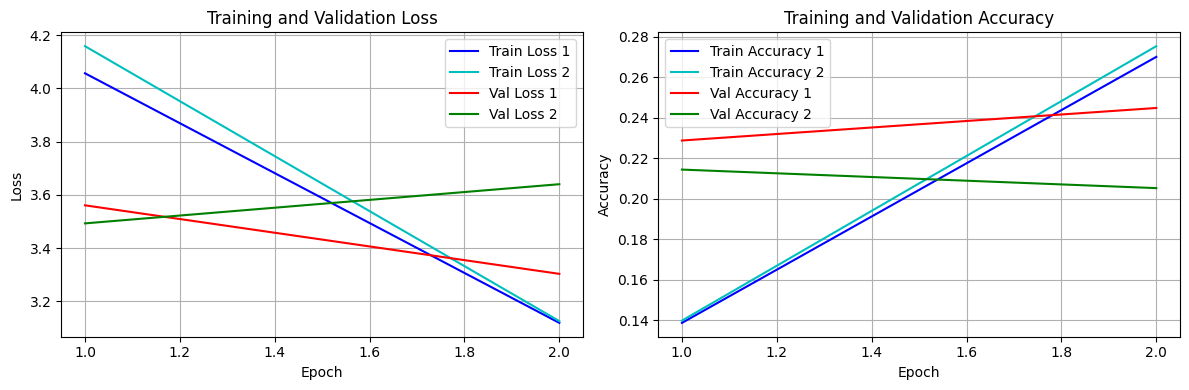

In [ ]:
model = Model2(src_vocab_size=len(dataset1.vocab),
          tgt_vocab_size=len(dataset1.vocab),
          d_model=512,
          nhead=8,
          dim_feedforward=1024,
          num_encoder_layers=6,
          num_decoder_layers=6,
          dropout = 0.1)

trainer = train_transformer(model, dataloader_1, dataloader_2, valloader_1, valloader_2, dataset1, load_path = '/content/checkpoints1/best_model.pt', phase = 2 , num_epochs=1)